# Немного о многоруких бандитах

В ноутбуке про многоруких бандитов мы разбирали классы для реализации отдельных стратегий решения задачки. Реализуйте в той же парадигме стратегии [exp3](https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/) и [softmax](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html) стратегии. Да, вы не ошиблись, они уже сделаны, надо понять, как оно работает и сделать так, чтобы оно работало в использованной нами конфигурации)

В конце концов, вы ж на работе тоже нон-стоп гуглите)


In [1]:
import time
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Классы из семинарского ноутбука

In [2]:
# Общий класс для Бернуллиевских бандитов
class BernoulliBandit():
    def __init__(self, n, probas=None):
        """
        n (int): Количество ручек.
        probas (list | None): Вероятности выигрыша для каждой ручки.
        """
        assert probas is None or len(probas) == n

        # Количество ручек
        self.n = n

        # Определим истинные вероятности ручек
        if probas is None:
            # Случайные вероятности
            np.random.seed(int(time.time()))
            self.probas = [np.random.random() for _ in range(self.n)]
        else:
            # Переданные в аргумент вероятности
            self.probas = probas

        # Вероятность оптимальной ручки
        self.best_proba = max(self.probas)
        
    def generate_reward(self, i: int) -> int:
        # Генерация выигрыша для i-й ручки бандита
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0
        

# Общий класс для стратегии решения
class Solver(object):
    def __init__(self, bandit):
        """
        bandit (Bandit): Инициализация бандита.
        """
        assert isinstance(bandit, BernoulliBandit)
        np.random.seed(int(time.time()))

        self.bandit = bandit

        self.counts = [0] * self.bandit.n  # Количество дерганий каждой ручки
        self.actions = []  # id ручек, которые дергали на каждом шаге
        self.regret = 0.  # Суммарная ошибка
        self.regrets = [0.]  # История ошибки
        self.reward = 0.  # Суммарный выигрыш
        self.rewards = [0.]  # История выигрыша

    def update_regret(self, i):
        # i (int): Индекс выбранной ручки.
        self.regret += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)

    def update_reward(self, i):
        # i (int): Индекс выбранной ручки.
        # Накопленная награда self.reward будет обновляться в другой функции
        self.rewards.append(self.reward)

    # Dummy-метод оценки вероятностей (переопределяется для каждого solver'a)    
    @property
    def estimated_probas(self):
        raise NotImplementedError

    # Dummy-метод перехода на следующий шаг (переопределяется для каждого solver'a)  
    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError
    
    # Запуск работы бандита на num_steps шагов
    def run(self, num_steps):
        assert self.bandit is not None

        for _ in range(num_steps):
            i = self.run_one_step()
            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)
            self.update_reward(i)


# e-жадная стратегия
class EpsilonGreedy(Solver):
    def __init__(self, bandit, eps, initial_proba=1.0):
        """
        eps (float): Вероятность исследования случайной ручки.
        init_proba (float): начальное значение =  1.0;
        """
        # Сделали бандита
        super(EpsilonGreedy, self).__init__(bandit)

        assert 0. <= eps <= 1.0
        # Задали epsilon
        self.eps = eps
        
        self.estimates = [initial_proba] * self.bandit.n  # Оптимистичная инициализация

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        if np.random.random() < self.eps:
            # Дернули случайную ручку
            i = np.random.randint(0, self.bandit.n)
        else:
            # Выбрали наилучшую (на данный момент) ручку
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        r = self.bandit.generate_reward(i)
        
        self.reward += r
        
        # Оценка для i-того бандита обновляется
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i
    

# UCB1 стратегия
class UCB1(Solver):
    def __init__(self, bandit, initial_proba=1.0):
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.estimates = [initial_proba] * self.bandit.n

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        self.t += 1

        # Выбрать лучшую ручку с учетом UCB.
        i = max(range(self.bandit.n), key=lambda x: self.estimates[x] + np.sqrt(
            2 * np.log(self.t) / (1 + self.counts[x])))
        r = self.bandit.generate_reward(i)
        
        self.reward += r

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i
    

# BayesianUCB стратегия
class BayesianUCB(Solver):
    """Предположим априорное Бета-распределение."""

    def __init__(self, bandit, c=2, init_a=1, init_b=1):
        """
        c (float): Сколько стандартных отклонений рассматривать в качестве UCB.
        init_a (int): Исходное значение a в Beta(a, b).
        init_b (int): Исходное значение b в Beta(a, b).
        """
        super(BayesianUCB, self).__init__(bandit)
        self.c = c
        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / float(self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        # Выбрать лучшую ручку с учетом UCB.
        i = max(
            range(self.bandit.n),
            key=lambda x: self._as[x] / float(self._as[x] + self._bs[x]) +\
            beta.std(self._as[x], self._bs[x]) * self.c
        )
        r = self.bandit.generate_reward(i)
        
        self.reward += r
        # Обновление апостериорного бета-распределения
        self._as[i] += r
        self._bs[i] += (1 - r)

        return i
    

# Семплирование Томпсона
class ThompsonSampling(Solver):
    def __init__(self, bandit, init_a=1, init_b=1):
        """
        init_a (int): Исходное значение a в Beta(a, b).
        init_b (int): Исходное значение b в Beta(a, b).
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / (self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        samples = [np.random.beta(self._as[x], self._bs[x]) for x in range(self.bandit.n)]
        i = max(range(self.bandit.n), key=lambda x: samples[x])
        r = self.bandit.generate_reward(i)
        
        self.reward += r
        self._as[i] += r
        self._bs[i] += (1 - r)

        return i

## EXP3

In [3]:
class EXP3(Solver):
    def __init__(self, bandit, gamma=0.0):
        super(EXP3, self).__init__(bandit)
        self.gamma = gamma  # параметр гамма
        self.weights = [1.0] * self.bandit.n  # веса
        self.estimates = [1.0] * self.bandit.n  # оценки вероятностей выигрыша для каждой ручки
        self.estimated_rewards = [0.0] * self.bandit.n  # оценки выигрыша 

    @property
    def estimated_probas(self):
        return self.estimates
    
    def run_one_step(self):
        sum_weights = sum(self.weights)
        probabilities = [(1-self.gamma) * w / sum_weights + self.gamma / self.bandit.n for w in self.weights]

        # Выбираем ручку
        thresh = np.random.random()  # генерируем случайное число от 0 до 1
        cum_prob = 0.0
        i = None
        for idx, prob in enumerate(probabilities):
            if cum_prob <= thresh <= cum_prob + prob:
                i = idx
            cum_prob += prob
        
        # Дает аналогичный результат
        # i = np.random.choice(range(self.bandit.n), p=probabilities, replace=False)

        # Генерируем выигрыш
        r = self.bandit.generate_reward(i)
        self.reward += r

        # Обновляем оценки выигрыша и веса по правилам стратегии
        for j in range(self.bandit.n):
            if j == i:
                self.estimated_rewards[j] = r / probabilities[j]
            else:
                self.estimated_rewards[j] = 0

            self.weights[j] *= np.exp(self.gamma * self.estimated_rewards[j] / self.bandit.n)
        
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

## Softmax

In [4]:
class Softmax(Solver):
    def __init__(self, bandit, tau=1.0):
        super(Softmax, self).__init__(bandit)
        self.tau = tau  # температура
        self.estimates = [1] * self.bandit.n  # оценки вероятностей выигрыша для каждой ручки
    
    @property
    def estimated_probas(self):
        return self.estimates
    
    def run_one_step(self):
        sum_exps = sum([np.exp(q / self.tau) for q in self.estimates])  # знаменатель для функции softmax
        probabilities = [np.exp(q / self.tau) / sum_exps for q in self.estimates]

        # Выбираем ручку
        thresh = np.random.random()
        cum_prob = 0.0
        i = None
        for idx, prob in enumerate(probabilities):
            if cum_prob <= thresh <= cum_prob + prob:
                i = idx
            cum_prob += prob
        
        # Дает аналогичный результат
        # i = np.random.choice(range(self.bandit.n), p=probabilities, replace=False)
    
        # Генерируем выигрыш
        r = self.bandit.generate_reward(i)
        self.reward += r

        # Обновляем оценку выигрыша для выбранной ручки
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

## Функции для рисования и экспериментов из семинарского ноутбука

In [7]:
def plot_results(solvers, solver_names):
    """
    Отрисовка результатов различных стратегий для бандитов.
    Args:
        solvers (list с типом Solver): Список решений проблемы бандитов, которые нужно подгонять.
        solver_names (list с типом str)
    """
    assert len(solvers) == len(solver_names)
    assert all(map(lambda s: isinstance(s, Solver), solvers))
    assert all(map(lambda s: len(s.regrets) > 0, solvers))

    b = solvers[0].bandit

    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    for i, s in enumerate(solvers):
        ax4.plot(range(len(s.rewards)), s.rewards, label=solver_names[i])

    ax4.set_xlabel('Время')
    ax4.set_ylabel('Выигрыш')
    
    # Рисунок. 1: Зависимость ошибки от времени.
    for i, s in enumerate(solvers):
        ax1.plot(range(len(s.regrets)), s.regrets, label=solver_names[i])

    ax1.set_xlabel('Время')
    ax1.set_ylabel('Накопленная ошибка')
    ax1.legend()
    # ax1.legend(loc=9, bbox_to_anchor=(1.82, -0.25), ncol=5)
    ax1.grid('k', ls='--', alpha=0.3)    

    # Рисунок. 2: Вероятности, оцененные алгоритмами.
    sorted_indices = sorted(range(b.n), key=lambda x: b.probas[x])
    ax2.plot(range(b.n), [b.probas[x] for x in sorted_indices], 'k--', markersize=12)
    for s in solvers:
        ax2.plot(range(b.n), [s.estimated_probas[x] for x in sorted_indices], 'x', markeredgewidth=2)
    ax2.set_xlabel('Ручки, отсортированные по ' + r'$\theta$')
    ax2.set_ylabel('Оцененная алгоритмом '+ r'$\hat\theta$')
    ax2.grid('k', ls='--', alpha=0.3)

    # Рисунок 3: Кол-во действий
    for s in solvers:
        ax3.plot(range(b.n), np.array(s.counts) / float(len(solvers[0].regrets)), ds='steps', lw=2)
    ax3.set_xlabel('Ручки')
    ax3.set_ylabel('Доля каждой ручки в общем кол-ве действий')
    ax3.grid('k', ls='--', alpha=0.3)
    
    plt.show()


def experiment(K, N, probas = []):
    """
    Прогонка эксперимента с бернуллиевским бандитом с K руками,
    в каждой из которых случайно задается вероятность выигрыша.
    Args:
        K (int): Кол-во ручек.
        N (int): Кол-во испытаний.
        test_solvers: Список моделей решения задачи о Бандите(эпсилон-жадная, UCB и тд)
        names: Список названий стратегий для графиков
    """
    if probas == []:
        probas = list(np.round(np.random.random(K),2))
    b = BernoulliBandit(K, probas = probas)
    print("Истинные вероятности выигрыша у Бернуллиевского бандита:\n", b.probas)
    print("У лучшей ручки индекс: {} и вероятность: {}".format(
        max(range(K), key=lambda i: b.probas[i]), max(b.probas)))
    
    test_solvers = [
        # EpsilonGreedy(b, eps = 0, initial_proba = 0),
        # EpsilonGreedy(b, 1),
        # EpsilonGreedy(b, 0.01),
        EpsilonGreedy(b, 0.05),
        UCB1(b),
        BayesianUCB(b, 2, 1, 1),
        ThompsonSampling(b, 1, 1),
        EXP3(b, gamma=0.05),
        # EXP3(b, gamma=0.1),
        # EXP3(b, gamma=0.2),
        # EXP3(b, gamma=1),  # полностью случайное дергание ручек, но при большом числе шагов переполнение весов 
        # Softmax(b, tau=0.05),
        Softmax(b, tau=0.1),
        # Softmax(b, tau=0.2),
        # Softmax(b, tau=1),
    ]
    names = [
        # 'Full-exploitation',
        # 'Full-exploration',
        # r'$\epsilon$' + '-Greedy 0.01',
        r'$\epsilon$' + '-Greedy 0.05',
        'UCB1',
        'Bayesian UCB',
        'Thompson Sampling',
        'EXP3 0.05',
        # 'EXP3 0.1',
        # 'EXP3 0.2',
        # 'EXP3 1',
        # 'Softmax, 0.05',
        'Softmax 0.1',
        # 'Softmax 0.2',
        # 'Softmax 1'
    ]

    for s in tqdm(test_solvers):
        s.run(N)

    plot_results(test_solvers, names)

    return test_solvers

## Эксперименты

### Сравниваем разные варианты EXP3 и Softmax между собой

Истинные вероятности выигрыша у Бернуллиевского бандита:
 [0.24, 0.89, 0.24, 0.16, 0.2, 0.74, 0.06, 0.89, 0.62, 0.85]
У лучшей ручки индекс: 1 и вероятность: 0.89


  0%|          | 0/7 [00:00<?, ?it/s]

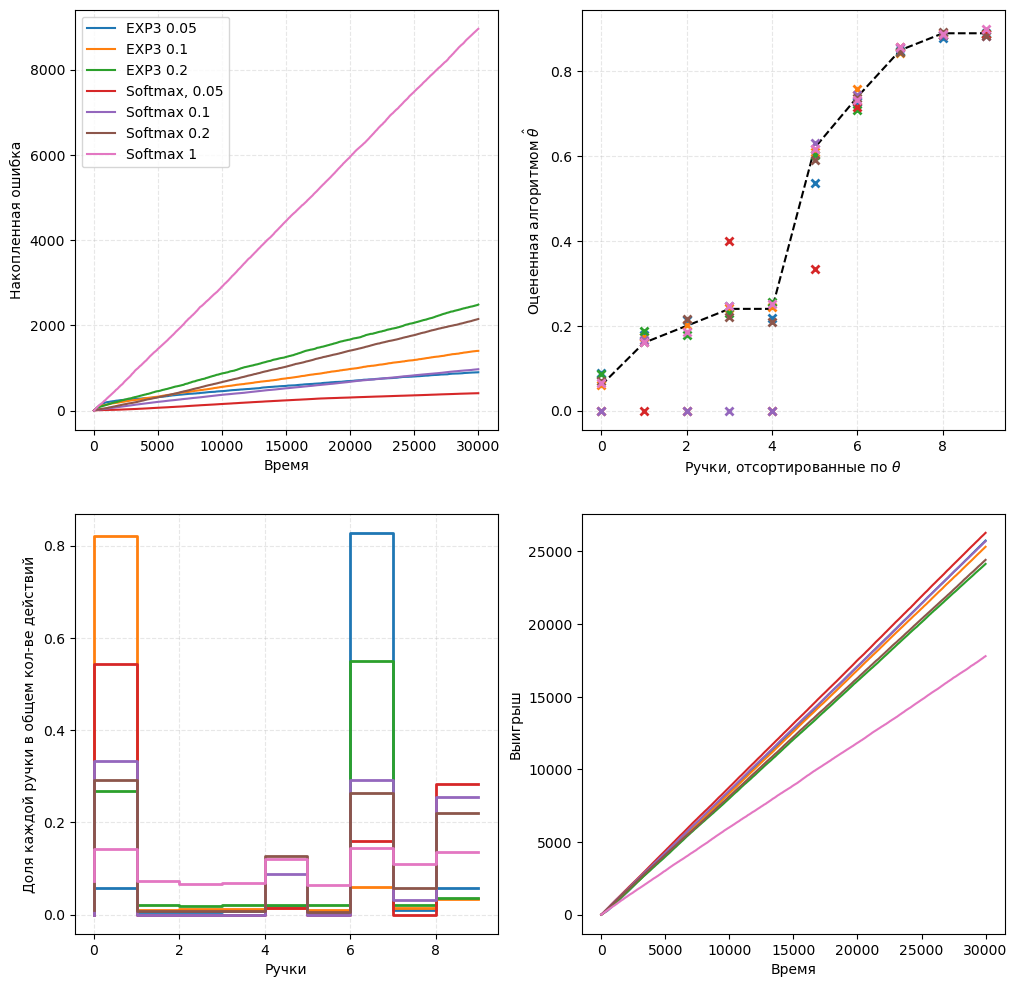

In [47]:
solvers = experiment(10, 30000)

Заметим, что дергается как ручка с индексом 1, так и ручка с индексом 7 - у них одинаковые истинные вероятности выигрыша 0.89. Так же некоторые из стратегий часто дергают ручку с индексом 9, у которой истинная вероятность выигрыша 0.85. Думаю, в целом это показывает, что стратегии находят наиболее привлекательные ручки с точки зрения вероятности выигрыша.

In [45]:
# Если посмотреть на веса, то они улетают в космос конечно из-за экспоненты...
exp3_solver = solvers[1]
print(f'EXP3 with gamma = {exp3_solver.gamma}')
exp3_solver.weights

EXP3 with gamma = 0.1


[8422583951403.265,
 1.4485830891217984e+67,
 1.875546609726511e+128,
 65006.944304747805,
 7.212757625769618e+68,
 1.4484187751064958e+109,
 9.769970893701056e+128,
 1410104428563.565,
 202380378.82687753,
 1.666230741819806e+70]

### Сравнение EXP3 и Softmax с другими стратегиями
Возьмем EXP3 с $\gamma = 0.05$ и Softmax с $\tau = 0.1$

Истинные вероятности выигрыша у Бернуллиевского бандита:
 [0.59, 0.95, 0.01, 0.45, 0.36, 0.96, 0.59, 0.98, 0.48, 0.54]
У лучшей ручки индекс: 7 и вероятность: 0.98


  0%|          | 0/6 [00:00<?, ?it/s]

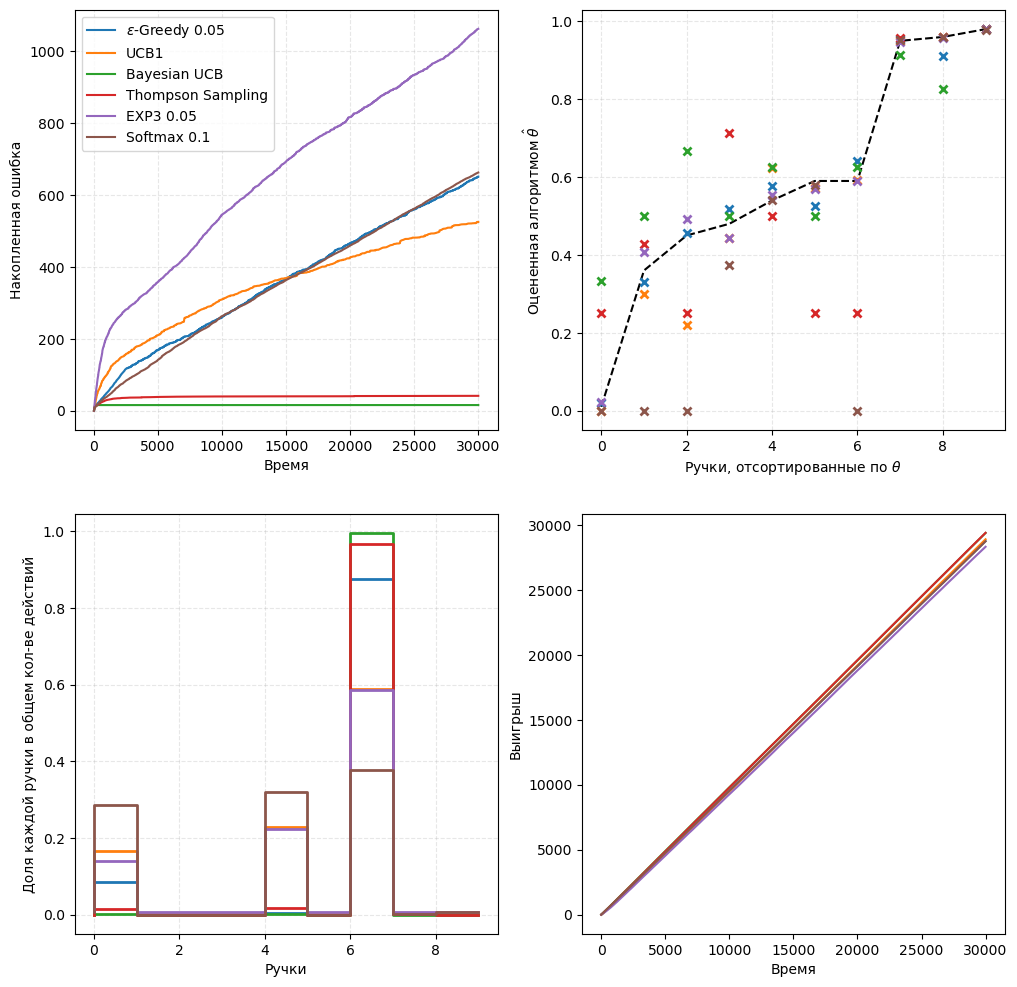

In [8]:
solvers = experiment(10, 30000)

## Выводы
- стратегии довольно быстро вычисляются и работают, несмотря на наличие экспоненты
- EXP3 и Softmax уступают некоторым другим стратегиям: Bayesian UCB, Thompson Sampling, UCB1
- возникает переполнение весов в случае большого числа испытаний
- стратегии хорошо ищут выгодные ручки

# Задание про АБ

Вот вам функция для расчета размера выборки (тот противный вывод, который я показывал).
Вероятно для оценки размера выборки вы видели вот такую формулу.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

<img src = "https://alexanderdyakonov.files.wordpress.com/2019/05/d0b01.jpg?w=700">


Вспомните, какие там предположения были

Предположения:
- нормальное распределение показателя
- равенство стандартных отклонений в 2 группах

In [1]:
from scipy.stats import norm

In [2]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

Представим, что у вас есть данные АБ-теста [следующего](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop) вида

Я их скачал и посчитал по дням разные виды событий
    

In [3]:
import pandas as pd
import duckdb
import hashlib

In [4]:
df = pd.read_csv('2019-Dec.csv')

In [5]:
df.event_type.unique()

array(['remove_from_cart', 'view', 'cart', 'purchase'], dtype=object)

In [14]:
q = '''
select CAST(event_time as date) as dt,
    count(distinct user_id) as users,
    count(distinct user_session) as user_sessions,
    sum(case when event_type = 'cart' then 1 else 0 end) as add_to_cart,
    sum(case when event_type = 'view' then 1 else 0 end) as view,
    sum(case when event_type = 'purchase' then 1 else 0 end) as purchase
from df
group by 1
order by 1
'''
duckdb.query(q).to_df()

,dt,users,user_sessions,add_to_cart,view,purchase
0,2019-12-01,17540,29616,34525.0,59528.0,7236.0
1,2019-12-02,19391,31948,36202.0,64921.0,9079.0
2,2019-12-03,18735,30841,38986.0,63503.0,8217.0
3,2019-12-04,18836,30422,37450.0,65472.0,8371.0
4,2019-12-05,18183,29983,33650.0,61445.0,7767.0
5,2019-12-06,16948,28074,32779.0,56883.0,7383.0
6,2019-12-07,15508,26036,28769.0,53910.0,6023.0
7,2019-12-08,16835,26968,33089.0,57435.0,6595.0
8,2019-12-09,19777,33980,41938.0,73983.0,9294.0
9,2019-12-10,19336,32876,38997.0,68677.0,9794.0


Допустим, сейчас 15ое число и вам доступны только данные за 1-14. Вы хотите спланировать АБ-тест длительностью в 2 недели и проверить необходимых размер выборки, чтобы на горизонте в 2 недели уметь замечать изменения масштабом в 4% в показателях:

* Среднее кол-во сессий на пользователя за 2 недели
* Среднее кол-во заказов на сессию за 2 недели
* Среднее кол-во добавлений в корзину на пользователя за за 2 недели

Заметьте, что в подобном тесте единицей рандомизации является ПОЛЬЗОВАТЕЛЬ (а значит события типа "кол-во заказов на сессию" - не независимая выборка)

Проверьте, какой размер выборки вам подскажет "точная формула", которую мы вывели в прошлый раз и насколько это отличается от результата, который вы бы получили:

* бутстрепом

* Линеаризацией ratio + t-тестом

Линеаризация [раз](https://www.researchgate.net/publication/322969314_Consistent_Transformation_of_Ratio_Metrics_for_Efficient_Online_Controlled_Experiments), Линеаризация [два](https://habr.com/ru/companies/kuper/articles/768826/)


- А кааааак мне Монтееее-Кааааааааарлооооооо сдееееелать с эээээтим бутстрееееееепом твоиииииииииииим?

- а вот [так](https://habr.com/ru/articles/780932/)

## Вычисляем нужные метрики по доступным данным

In [18]:
# Преобразуем строковую дату-время в тип datetime
df.event_time = pd.to_datetime(df.event_time)

In [29]:
# Выбираем доступные данные за 1-14 декабря
df_first_2_weeks = df[df.event_time.dt.day.isin(range(1, 15))]
df_first_2_weeks

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00+00:00,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00+00:00,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02+00:00,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05+00:00,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07+00:00,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
...,...,...,...,...,...,...,...,...,...
1835986,2019-12-14 23:59:47+00:00,remove_from_cart,5802432,1487580009286598681,NaN,NaN,0.32,587043507,dd1eaed7-f72f-4de7-b4d2-d63b694ff591
1835987,2019-12-14 23:59:49+00:00,cart,5870216,1487580008288355308,NaN,levrana,2.38,568399819,47be87a9-ce02-46b2-9513-28b8bcc01ede
1835988,2019-12-14 23:59:50+00:00,cart,5711120,1487580005008409427,NaN,f.o.x,6.03,246049789,f8182d3b-24ee-4b27-813a-a0d423ef109a
1835989,2019-12-14 23:59:56+00:00,view,5726396,1487580005092295511,NaN,NaN,5.56,579604389,7dfeaa81-be42-40a7-a1a0-5b55c5284131


In [37]:
# Количество уникальных пользователей за эти 2 недели
user_ids = df_first_2_weeks.user_id.unique()
print('Количество уникальных пользователей с 1 по 14 декабря:', len(user_ids))

Количество уникальных пользователей с 1 по 14 декабря: 191551


In [135]:
# Есть пользователи с user_session, равным NaN
df_first_2_weeks[df_first_2_weeks.user_session.isna()]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,group_id
5224,2019-12-01 03:49:31+00:00,cart,5561488,1487580007952810971,NaN,NaN,10.63,403325248,NaN,0
5226,2019-12-01 03:49:33+00:00,cart,5561488,1487580007952810971,NaN,NaN,10.63,403325248,NaN,0
7792,2019-12-01 05:19:33+00:00,remove_from_cart,5742415,1487580009051717646,NaN,NaN,34.90,580025231,NaN,1
7800,2019-12-01 05:19:43+00:00,remove_from_cart,5778747,1638456119066100510,NaN,pole,4.11,580025231,NaN,1
7801,2019-12-01 05:19:43+00:00,remove_from_cart,5778747,1638456119066100510,NaN,pole,4.11,580025231,NaN,1
...,...,...,...,...,...,...,...,...,...,...
1831463,2019-12-14 22:16:40+00:00,cart,5770017,1487580013841613016,NaN,kapous,2.81,587031769,NaN,1
1831466,2019-12-14 22:16:43+00:00,cart,5770017,1487580013841613016,NaN,kapous,2.81,587031769,NaN,1
1831476,2019-12-14 22:16:52+00:00,cart,5770017,1487580013841613016,NaN,kapous,2.81,587031769,NaN,1
1831479,2019-12-14 22:16:56+00:00,cart,5770017,1487580013841613016,NaN,kapous,2.81,587031769,NaN,1


In [139]:
# sessions - количество сессий на каждого пользователя за 2 недели, используется nunique(dropna=False), так как есть 400 пользователей с user_session NaN
# adding_to_cart - количество добавлений в корзину на каждого пользователя за 2 недели
# purchases - количество заказов на пользователя

metrics = df_first_2_weeks.groupby('user_id').agg(
    sessions=('user_session', lambda x: x.nunique(dropna=False)),
    adding_to_cart=('event_type', lambda event: sum(event == 'cart')),
    purchases=('event_type', lambda event: sum(event == 'purchase'))
)

In [148]:
# Среднее количество заказов на сессию у каждого пользователя за 2 недели
metrics['purchases_per_session'] = metrics.purchases / metrics.sessions

metrics.head()

,sessions,adding_to_cart,purchases,purchases_per_session
user_id,,,,
4661182,1,1,0,0.0
6406435,1,0,0,0.0
8194617,1,3,0,0.0
9794320,4,1,0,0.0
15400971,2,3,3,1.5


## Расчет размера выборки по формуле

In [205]:
# Изменения по условию 4%, ищем абсолютное изменение каждого показателя
epsilons = {metric: 0.04 * metrics[metric].mean() for metric in metrics.columns}

# Считаем std
stds = metrics.std()

# Воспользуемся формулой, alpha=0.05, beta=0.2 по умолчанию
sample_sizes = {}
for metric in ['sessions', 'adding_to_cart', 'purchases_per_session']:
    sample_sizes[metric] = compute_sample_size_abs(epsilons[metric], stds[metric], stds[metric])

pd.Series(sample_sizes, name='Sample size for AB')

sessions                 400549
adding_to_cart           225474
purchases_per_session    540949
Name: Sample size for AB, dtype: int64

## Бутстреп

Для начала разделим пользователей на 100 групп (бакетов) с помощью хеша.

In [217]:
# Функция для деления пользователей на группы
def split_by_groups(user_id, n_groups=2):
    hash_argument = (str(user_id)).encode()
    hexdigest = hashlib.md5(hash_argument).hexdigest()
    group_id = int(hexdigest, base=16) % n_groups
    return group_id

n_groups = 100
metrics.loc[:, 'group_id'] = metrics.index.to_series().map(lambda user_id: split_by_groups(user_id, n_groups))
metrics.head()

,sessions,adding_to_cart,purchases,purchases_per_session,group_id
user_id,,,,,
4661182,1,1,0,0.0,74
6406435,1,0,0,0.0,99
8194617,1,3,0,0.0,15
9794320,4,1,0,0.0,27
15400971,2,3,3,1.5,49


Пользуясь статьей и рассказанным на лекции, рассчитаем с помощью бутстрепа размер выборки.

In [291]:
import numpy as np

def get_bootstrap_samples(test, control, B=1000):
    size = min(len(test), len(control))
    test_bootstrap = np.random.choice(test, size=(B, size), replace=True)
    control_bootstrap = np.random.choice(test, size=(B, size), replace=True)

    return test_bootstrap, control_bootstrap

Реализована идея, которую рассказывали на лекции: с шагом по размеру выборки генерировать 1000 выборок размера N без изменений и 1000 выборок размера N с изменениями (в нашем случае 4%).

In [315]:
from scipy.stats import shapiro

def bootstrap_for_sample_size(metrics, 
                              metric_name,
                              slices=[1, 2.5, 5, 10, 20, 30, 40, 50],
                              relative_epsilon=0.04, 
                              alpha=0.05):

    shapiro_pvalues = []
    epsilons = []
    ci_left_bounds = []
    ci_right_bounds = []
    minimum_lift = []
    mde = []
    sample_percent = []
    sample_size = []

    for i in slices:
        # Взяли выборку из генеральной совокупности
        control = metrics[metrics['group_id'] < i][metric_name].to_numpy().astype('float')

        # Добавили изменение величиной 4%, то есть по сути сдвинули распределение
        abs_epsilon = relative_epsilon * control.mean()
        epsilons.append(abs_epsilon)
        test = control + abs_epsilon

        # Генерируем бутстрепные выборки с изменением и без изменения 
        test_bootstrap, control_bootstrap = get_bootstrap_samples(test, control)
        
        # Считаем средние
        test_bootstrap_means = test_bootstrap.mean(axis=1)
        control_bootstrap_means = control_bootstrap.mean(axis=1)
        
        # Находим разницы в средних
        diff_means = test_bootstrap_means - control_bootstrap_means

        # Проверка на нормальность распределения разниц в средних критерием Шапиро-Уилка
        shapiro_pvalues.append(shapiro(diff_means).pvalue)

        # Доверительный интервал
        ci_left, ci_right = np.quantile(diff_means, [alpha/2, 1 - alpha/2])
        ci_left_bounds.append(ci_left)
        ci_right_bounds.append(ci_right)

        # Считаем minimum lift и MDE
        min_lift = (ci_right - ci_left) / 2
        minimum_lift.append(min_lift)
        mde.append(min_lift / control_bootstrap.std())

        sample_percent.append(i)
        sample_size.append(len(test))

    result = pd.DataFrame({'absolute_epsilon': epsilons,
                           'minimum_lift': minimum_lift,
                           'ci_left': ci_left_bounds,
                           'ci_right': ci_right_bounds,
                           'mde': mde,
                           'shapiro_pvalues': shapiro_pvalues, 
                           'sample_percent': sample_percent, 
                           'sample_size': sample_size})

    return result

In [287]:
# Количество сессий на пользователя
bootstrap_for_sample_size(metrics, 'sessions', slices=[1, 2.5, 5, 10, 20, 30, 40, 50])

,absolute_epsilon,minimum_lift,ci_left,ci_right,mde,shapiro_pvalues,sample_percent,sample_size
0,0.086681,0.277406,-0.278222,0.276590,0.065590,0.527276,1.0,1808
1,0.082711,0.139039,-0.139389,0.138688,0.034883,0.735352,2.5,5711
2,0.081775,0.112609,-0.112768,0.112450,0.027251,0.325315,5.0,9508
3,0.083154,0.093282,-0.089777,0.096787,0.020071,0.464549,10.0,19086
4,0.084241,0.077840,-0.080309,0.075372,0.013591,0.676016,20.0,38244
5,0.084243,0.062773,-0.063164,0.062383,0.011322,0.609066,30.0,57679
6,0.087931,0.210468,-0.210956,0.209981,0.010324,0.328594,40.0,76695
7,0.087216,0.169993,-0.160560,0.179426,0.009206,0.019864,50.0,95781


Не совсем понимаю, на какой показатель тут нужно смотреть, чтобы выбрать нужный размер выборки. Если смотрим на MDE, тогда из получившихся данных минимальным размером выборки, с помощью которого можно заметить изменения масштабом 4% по метрике sessions, является 1808 пользователя (1% от всего числа пользователей за 2 недели).

А если смотреть на minimum_lift и искать, когда он становится меньше абсолютного изменения, то это будет 38244 пользователя (20% от всего числа пользователей).

In [316]:
# Количество добавлений в корзину на пользователя
bootstrap_for_sample_size(metrics, 'adding_to_cart', slices=[2.5, 5, 10, 20, 30, 40, 50, 60])

,absolute_epsilon,minimum_lift,ci_left,ci_right,mde,shapiro_pvalues,sample_percent,sample_size
0,0.122858,0.883606,-0.869554,0.897658,0.035118,0.335801,2.5,5711
1,0.115284,0.578882,-0.601743,0.556021,0.028196,0.115728,5.0,9508
2,0.112520,0.350295,-0.349502,0.351087,0.020754,0.617888,10.0,19086
3,0.106711,0.187256,-0.187204,0.187308,0.013569,0.444262,20.0,38244
4,0.103798,0.150474,-0.148340,0.152608,0.011978,0.820326,30.0,57679
5,0.104889,0.144265,-0.143779,0.144751,0.010125,0.285902,40.0,76695
6,0.104174,0.120668,-0.119598,0.121737,0.008889,0.870048,50.0,95781
7,0.103272,0.104513,-0.100852,0.108174,0.007988,0.729803,60.0,114854


Аналогично, если смотреть на minimum_lift, то для метрики adding_to_cart минимальный размер выборки 114854 пользователей (60% от всего числа пользователей за 2 недели).

In [319]:
# Количество заказов на сессию
bootstrap_for_sample_size(metrics, 'purchases_per_session', slices=[2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80])

,absolute_epsilon,minimum_lift,ci_left,ci_right,mde,shapiro_pvalues,sample_percent,sample_size
0,0.008947,0.045540,-0.042014,0.049066,0.036410,0.187167,2.5,5711
1,0.008739,0.034472,-0.034726,0.034218,0.027778,0.824003,5.0,9508
2,0.009310,0.025135,-0.025195,0.025075,0.018250,0.435354,10.0,19086
3,0.009231,0.019904,-0.019508,0.020299,0.014226,0.346374,20.0,38244
4,0.009244,0.018550,-0.018374,0.018726,0.011364,0.422323,30.0,57679
5,0.009467,0.016870,-0.016746,0.016995,0.009616,0.310003,40.0,76695
6,0.009569,0.015504,-0.014829,0.016178,0.008826,0.337071,50.0,95781
7,0.009490,0.013476,-0.013697,0.013255,0.007796,0.059928,60.0,114854
8,0.009532,0.013268,-0.012844,0.013693,0.007803,0.793161,70.0,134129
9,0.009479,0.011945,-0.012028,0.011862,0.006959,0.393989,80.0,153252


Аналогично, если смотреть на minimum_lift, для метрики purchases_per_session минимальный размер выборки 153252 пользователей (60% от всего числа пользователей за 2 недели).

## Линеаризация ratio + t-test

У нас есть ratio-метрика - среднее количество заказов на сессию, в числителе сумма количества заказов, в знаменателе сумма сессий. 

In [385]:
from scipy.stats import ttest_ind

def lin(num, denom, ratio_control):
    return num - ratio_control * denom

relative_epsilon = 0.04
p_values = []
sample_sizes = []

for users_percent in range(10, 51, 5):
    control = metrics[metrics['group_id'] < users_percent]
    test = metrics[(users_percent <= metrics['group_id']) & (metrics['group_id'] < 2*users_percent)]

    num_control = control.purchases
    denom_control = control.sessions
    num_test = test.purchases
    denom_test = test.sessions

    ratio_control = num_control.sum() / denom_control.sum()

    lin_test = lin(num_test, denom_test, ratio_control)
    lin_control = lin(num_control, denom_control, ratio_control)

    p_value = ttest_ind(lin_test, lin_control).pvalue
    p_values.append(p_value)

    sample_size = compute_sample_size_abs(relative_epsilon*ratio_control, lin_test.std(), lin_test.std())
    sample_sizes.append(sample_size)

In [386]:
print('p_values:', *p_values, sep='\n')

p_values:
0.9023527816730759
0.7266989766348868
0.15960241384945362
0.4297878283613126
0.542381095445949
0.6475233456816584
0.3997636000584732
0.9145866830965188
0.9397907241114662


In [387]:
print('sample sizes:', *sample_sizes, sep='\n')

sample sizes:
1630556
1528751
9064238
7970671
6780207
5960237
1822030
1676412
1935051


Не совсем понимаю, как это работает и как учитывать масштаб изменений, который мы хотим (4%). Получилось от 1.5 до 2 млн пользователей (?) 